## $\color{Green}{\text{GMD Table 4: GMSL from Workflows}}$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import netCDF4 as nc
from pandas.plotting import table 
import xarray as xr

#### $\color{blue}{\text{List of Modules and Data to be used}}$

In [2]:
# Load FACTS workflow data set names as a dataframe.
df_WF = pd.read_fwf( '001_IP_GMD_Table_names_Modules_Data/mod-submod-data_WF_global_Bob_amarel_V2.txt' )
df_WF


,Component,Workflow,Data_File
0,total,wf1e,total.workflow.wf1e.global.nc
1,total,wf1f,total.workflow.wf1f.global.nc
2,total,wf2e,total.workflow.wf2e.global.nc
3,total,wf2f,total.workflow.wf2f.global.nc
4,total,wf3e,total.workflow.wf3e.global.nc
5,total,wf3f,total.workflow.wf3f.global.nc
6,total,wf4,total.workflow.wf4.global.nc


#### $\color{Red}{\text{Load Module data from ==> facts-experiments}}$

In [3]:
EXPDATE     = 221217
MODNO       = df_WF.index.values;   # Number of datasets Module outputs
SCENARIO    = ['ssp126', 'ssp245','ssp585'];
#SCENARIO    = ['ssp119','ssp126', 'ssp245', 'ssp370', 'ssp585'];
YEAR        = 2100; # Percentile Year for the table.   
#
# Temp DF to store all .nc O/P.      
df_TEMP      = []
#        
for val in MODNO:
    for scenario in SCENARIO: 
        WORKFLOW = df_WF["Workflow"][val];  COMP = df_WF["Component"][val];  
        # Skip if data is absent.
        if df_WF["Data_File"][val] == 'XXX':
           continue 
        #
        # Pick the data files & Import nc file to dataframe. 
        dataFOLDER  = '/projects/kopp/facts-experiments/{arg2}/coupling.{arg1}/output/'.format(arg1=scenario,arg2=EXPDATE)
        dataFILE    = 'coupling.{arg1}.'.format(arg1=scenario) + df_WF["Data_File"][val]
        d_nc        = xr.open_dataset(dataFOLDER + dataFILE)
        d_nc
        #
        # Percentile calculation.
        percentList = [50, 17, 83]          #[50, 5, 17, 83, 95]
        # Find year index to pick SLC value
        Yind    = np.where(d_nc["years"].values == YEAR)[0][0]
        GMSL    = (d_nc["sea_level_change"][:,Yind,0].values)/10  # Convert to cmeters.
        # Find Percentiles.
        pcntle  = np.percentile(GMSL[:], percentList );    pcntle = np.around(pcntle,2)
        #
        TEMP = [COMP,WORKFLOW, scenario] + pcntle.tolist()
        df_TEMP.append( TEMP )
df_ptile = pd.DataFrame( df_TEMP, columns=['Component','Workflow','SSP', ] + [ f'col_{x}' for xi, x in enumerate( percentList )] )
#
df_ptile[''] = df_ptile.apply(lambda x: f'{x.col_50:2.2f} ({x.col_17:2.2f} , {x.col_83:2.2f})', axis=1 )
df_ptile1    = pd.DataFrame( df_ptile.set_index( ['Component', 'Workflow', 'SSP'] )[''] ).unstack().swaplevel( 0,1, axis=1 )
print('Percentile of GMSL [ median(17th,83rd) ] in cm for different workflows for the year ', YEAR)
df_ptile1


Percentile of GMSL [ median(17th,83rd) ] in cm for different workflows for the year  2100


SSP                                ssp126                 ssp245  \
                                                                   
Component Workflow                                                 
total     wf1e      39.90 (31.80 , 49.20)  50.10 (41.58 , 59.92)   
          wf1f      40.00 (31.50 , 48.90)  49.00 (39.80 , 58.60)   
          wf2e      45.70 (34.70 , 59.90)  57.10 (45.00 , 73.00)   
          wf2f      47.70 (38.40 , 61.82)  58.90 (48.40 , 74.40)   
          wf3e      40.40 (33.80 , 47.90)  51.40 (44.50 , 59.20)   
          wf3f      42.70 (37.20 , 48.82)  53.30 (47.00 , 60.10)   
          wf4       52.85 (37.28 , 80.23)  60.40 (44.40 , 87.92)   

SSP                                  ssp585  
                                             
Component Workflow                           
total     wf1e        70.60 (60.90 , 81.52)  
          wf1f        65.75 (54.78 , 78.32)  
          wf2e       79.80 (65.00 , 100.20)  
          wf2f       79.80 (66.30 , 100.25)  
          wf3e       96.70 (79.98 , 117.72)  
          wf3f       97.30 (81.20 , 117.42)  
          wf4       100.90 (69.20 , 163.53)

# <font color=red> Need to export the table. </font>

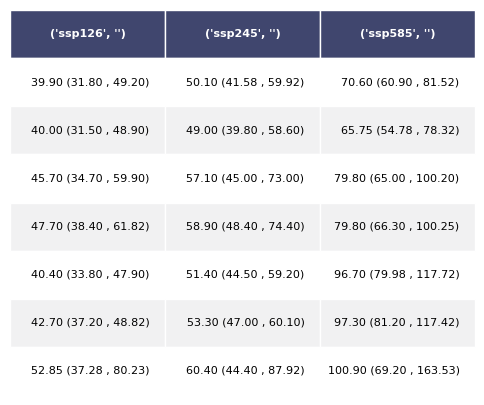

In [16]:
df = df_ptile1;

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=8,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(df, header_columns=0, col_width=2.0)
# fig.savefig("table_mpl.png")